# Dueling Network Architecture Implementation
The Duelling newtork is an artificial neural network architecture that has improved the state of the art in the DQN area used in combination with Dual DQN and Prioritized Expirience Replay. This approach splits the action value calculation using a combination of state value function and advantage function.

# Searching for available environments
We want to test the performance of our architecture with the Atari game 'BeamRider', we can check wich kind of version of this game are available.

In [1]:
from gym import envs

game_name = "BeamRider"

all_envs = envs.registry.values()
env_ids = [env_spec.id for env_spec in all_envs]

for id in sorted(env_ids):
    if game_name in id:
        print(id)


ALE/BeamRider-ram-v5
ALE/BeamRider-v5
BeamRider-ram-v0
BeamRider-ram-v4
BeamRider-ramDeterministic-v0
BeamRider-ramDeterministic-v4
BeamRider-ramNoFrameskip-v0
BeamRider-ramNoFrameskip-v4
BeamRider-v0
BeamRider-v4
BeamRiderDeterministic-v0
BeamRiderDeterministic-v4
BeamRiderNoFrameskip-v0
BeamRiderNoFrameskip-v4


/home/ste/anaconda3/lib/python3.9/site-packages/requests/packages/urllib3/_collections.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, MutableMapping


# Environment Configuration
We select the version 4 of the enviroment with no frameskipping and select as render mode rgb array. The no frameskipping is used to make this enviroment compatible with the optimization made by *AtariPreprocessing*.

In [1]:
import matplotlib.pyplot as plt
from gym import envs
from gym.wrappers import AtariPreprocessing

# Make Parameters:
game_name = "BeamRider"
game_mode = "NoFrameskip"  # [Deterministic | NoFrameskip | ram | ramDeterministic | ramNoFrameskip ]
game_version = "v4"  # [v0 | v4 | v5]
env_name = '{}{}-{}'.format(game_name, game_mode, game_version)
env_render_mode = 'rgb_array'  # [human | rgb_array]
env_frame_skip = 4

env = envs.make(env_name, render_mode=env_render_mode)

/home/ste/anaconda3/lib/python3.9/site-packages/requests/packages/urllib3/_collections.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, MutableMapping
A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
/home/ste/anaconda3/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/ste/anaconda3/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  depreca

In [2]:
env.reset() 
env.render(mode="rgb_array")

/home/ste/anaconda3/lib/python3.9/site-packages/gym/core.py:51: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/home/ste/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:297: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

## Envorment Observations
Below we have a fist look to the enviroment characteristics.

In [3]:
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

In [13]:
env.action_space

9

In [6]:
env.unwrapped.get_action_meanings()

['NOOP',
 'FIRE',
 'UP',
 'RIGHT',
 'LEFT',
 'UPRIGHT',
 'UPLEFT',
 'RIGHTFIRE',
 'LEFTFIRE']

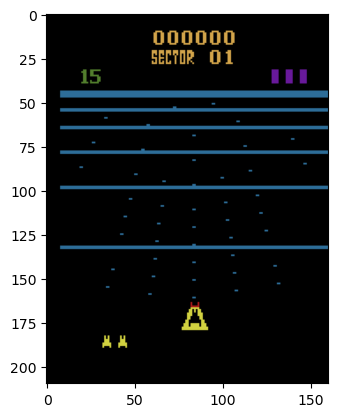

In [7]:
plt.imshow(env.render(mode=env_render_mode))

## Enviroment Optimization
We optimize the enviroment adding the frame skipping, changing its observation in greyscale and following the experiment did in the paper we set to at most 30 the no-op actions; to get this we use the AtariPreprocessing wrapper.

In [8]:
env_prep = AtariPreprocessing(env, frame_skip = env_frame_skip, grayscale_obs = True, noop_max = 30 ) #noop_max; screen_size

In [9]:
env_prep.reset()

/home/ste/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [10]:
env_prep.observation_space.shape

(84, 84)

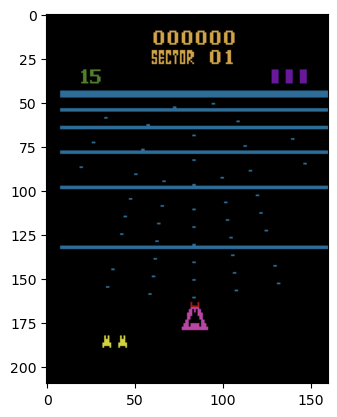

In [11]:
plt.imshow(env_prep.render(mode=env_render_mode))

# Network configuration

## Network parameters

In [12]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import losses 
from tensorflow.keras import optimizers

input_shape = env_prep.observation_space.shape
num_actions = env_prep.action_space.n
min_epsilon = 0.001

2022-09-14 17:44:33.257279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-14 17:44:33.865599: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-14 17:44:34.773513: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ste/anaconda3/lib/python3.9/site-packages/cv2/../../lib64::/home/ste/.mujoco/mujoco210/bin:/usr/lib/nvidia:/home/ste/anaconda3/lib/
2022-09-14 17:44:34.773673: W tensorflow/stream_executor/platform/default/

## Policy
The policy is the component that choose the action to perform; using an $\epsilon$-gready policy the action choosen can be a radom one with probability $\epsilon$ and an action suggested by the ANN with probability $1 - \epsilon$.
From paper: " When acting, it suffices to evaluate the advantage stream to make decisions."

In [13]:
def epsilon_greedy_policy(state, model, action_space_size, episode, min_epsilon=0):
    epsilon = max(1 - episode / 500, min_epsilon)

    if np.random.rand() < epsilon:
        return np.random.randint(action_space_size)
    else:
        q_values = model.predict(state[np.newaxis])
        return np.argmax(q_values[0])

## Neural Network Creation
The creation of the DQN Model is based on the example presented in https://keras.io/examples/rl/deep_q_network_breakout/. The network architecture proposed follows the structure proposed in *"Dueling Network Architectures for Deep Reinforcement Learning"* https://arxiv.org/abs/1511.06581 composed by 3 convolutional layers and 2 fully connected layer for each stream (advantage, value).
It's possible to create a dueling network using the `DQNAgent` of `rl.agents.dqn` setting `enable_dueling_network=True` in the constructor, but the perpouse of this experiment is to show how to develop it manually so that is not used.

The output of the value stream and the output of the advantage stream are merged to obtain the action-value function in the last module of the network using the following formula:
$$ Q(s, a; \theta, \alpha, \beta) = V (s;\theta, \beta) + ( A(s, a; \theta, \alpha) − max_{a' ∈|A|} A(s, a'; \theta, \alpha)) $$

Following the paper: 
"Since both the advantage and the value stream propagate gradients to the last convolutional layer in the backward pass, we rescale the combined gradient entering the last convolutional layer by $\frac{1} {\sqrt2}$."

In [14]:
from tensorflow.keras import layers
from tensorflow.keras import Model


def create_dueling_model(input_shape, action_number):
    inputs = layers.Input(shape=input_shape)

    # Convolutions on the frames on the screen
    layer1 = layers.Conv1D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv1D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv1D(64, 3, strides=1, activation="relu")(layer2)
    layer4 = layers.Flatten()(layer3)

    value_stream_1 = layers.Dense(512)(layer4)
    value_stream_2 = layers.Dense(1)(value_stream_1)  # scalar output size

    advantage_stream_1 = layers.Dense(512)(layer4)
    advantage_stream_2 = layers.Dense(action_number)(advantage_stream_1)  # output size equal to the actions available

    # Combination of the streams: a Q value for each state
    q_values = value_stream_2 + (advantage_stream_2 - tf.math.reduce_mean(advantage_stream_2, axis=1, keepdims=True))

    # Alternative q_value
    # q_value = value_stream_2 + (advantage_stream_2 - backend.max(advantage_stream_2, axis=1, keepdims=True))
    return Model(inputs=[inputs], outputs=[q_values])


# Training
The learnig step is executed with **Double Deep Q-networks** algorithm presented in the paper *"Deep reinforcement learning with double Q-learning"*.https://arxiv.org/pdf/1509.06461.pdf.

## Training parameters
We adopt as optimizer the **Adam** implementation setting the learning rate equal to $6.25x10^{-5}$ and **clipping the gradient** norm at most to 10; the parameters are specified in the paper "*Deep reinforcement learning with double Q-learning*" (https://arxiv.org/pdf/1509.06461.pdf)
To evaluate the loss score we use the `mean_squared_error`. 

In [15]:
batch_size = 32
buffer_size = 2000
loss_function = losses.mean_squared_error

discount_factor = 0.95
learning_rate = 6.25e-5
max_episodes = 600
primary_model_file_name = "dueling_primary_model.h5"
target_model_file_name = "dueling_target_model.h5"

# Setting the optimizer with the clipping to have the norm <= 10
optimizer = optimizers.Adam(learning_rate=learning_rate, clipnorm=10)

## Prioritized experience replay
The Prioritized experience replay was introduced in the paper "Prioritized experience replay" (https://arxiv.org/abs/1511.05952), it consists in an evolution in the replay buffer usage, ordering by priority the experience to replay. In this experiment we adopt the **rank-based** variant where the experience sampling from the buffer it's done with probability $ P(i) = \frac{p_{i}^{\alpha}}{\sum_k{p_{k}^{\alpha}}} $ and $p(i)=\frac{1}{rank(i)}$ where $rank(i)$ is the rank of the -ith transition when the buffer is sorted by the TD error $\delta$ of each experience; $\alpha$ is called **priority exponent**. Is also compute the importance sampling weights as $w_j = \frac{(N . P(i))^{-\beta}}{max_i{w_i}} $ and $w_i = (\frac{1}{N} . \frac{1}{P(i)})^\beta$

In both the paper the parameters are setted as follow: **priority exponent** $\alpha= 0.7$,  the **importance sampling exponent** $\beta = [0.5, 1]$.
In the paper is proposed a **heap array** structure to implement the buffer. Due to the particular structure and the amount of property of the replay buffer in the Prioritized Experience Replay, we choose to describe it as a class. The heap array structure is implemented as a deque sorted every *T* step.

In the Prioritized experience replay paper another kind of implementation in propoused that consistes in the divition of the buffer in a *batchsize* parts and sampling from them; this garantees to have a sample for each rank category. We follow the first implementation using the numpy *zipf* function.

### Replication Buffer

In [16]:
class PrioritizedExperienceReplay:
    def add_experience():
    def remove_experience():
    def sample_experience():

IndentationError: expected an indented block (2186788287.py, line 3)

In [17]:
#import heapq as heap

# We set a time to haepify to sort the buffer every K time step.
class PrioritizedExperienceReplayWithRank:
    """
    contains the tuples (TD_error, experience)
    replay_buffer --- its the max size of the buffer, over which before add an experience one is remove 
    max_buffer_size --- time step before sort the structure
    time_to_haepify --- the last time step
    mod_curr_step = 0  --- the alpha parameter used to calculate the probability of the i-th element P(i) to be sampled
    alpha
    """
    
    def __init__(self, alpha, max_buffer_size, time_to_haepify):
        self.replay_buffer = deque(maxlen=2000)
        self.alpha = alpha
        self.max_buffer_size = max_buffer_size
        self.mod_curr_step = 0
        self.time_to_haepify = time_to_haepify 
        
    def add_experience(self, experience, TD_error):
        if (len(self.replay_buffer) == self.max_buffer_size):
            self.remove_experience()
        
        self.replay_buffer.append((TD_error,self.experience))
        self.mod_curr_step += 1 
        
        if (self.mod_curr_step == time_to_haepify):
            self.replay_buffer.sort(reverse=True)

    def remove_experience(self):
        self.replay_buffer.pop(-1)
            
    def sample_experience(self, batch_size, beta):
        experiences = []
        importance_sampling_weight = []
        N = len(self.replay_buffer)
        
        for i in range(batch_size):    
            index = np.random.zipf(self.alpha, len(self.replay_buffer))
            
            ## Check to garantee that a specific index appear just once
            while index in indexes:
                index = np.random.zipf(self.alpha, N)
            
            Pj = 1/index
            importance_sampling_weight.append((N * Pj ** (-beta)))
            experiences.append(self.replay_buffer[index][1])
        
        ## Normalization step
        max_weight = max(importance_sampling_weight)
        importance_sampling_weight =/ max_weight
        
        return experiences, importance_sampling_weight    

       
        

SyntaxError: invalid syntax (3768136602.py, line 52)

## Play one step
With this function we want to ask to the policy what action must be choosen and perform it on the evniroment.

In [18]:
from tensorflow.keras.models import load_model

# Execs one action receiving in input the enviroment, its state
def play_one_step(env, state, model, replay_buffer, episode, action_space_size, min_epsilon = 0, training = True):
    action = epsilon_greedy_policy(state, model, action_space_size, episode, min_epsilon)
    print("action {}".format(action))
    next_state, reward, done, info = env.step(action)
    if training:
        replay_buffer.append(state, action, reward, next_state, done)
    return action, reward, next_state, done, info
    

## Gradient 
The gradient is the mathematical function that calcualte the weights update in the ANN following the gradient minimization tecnique. In our scenario the gradient that is backpropageted to the last convolutional layer must be rescaled by $\frac{1}{\sqrt{2}}$

In [19]:
## TODO Concludere le modifiche al gradiente
## TODO Scegliere come ripartire tra le funzioni le modifiche al gradiente
def gradient_computation(model, states, mask, loss_function, target_Q_values, axis=1, keepdims=True):
    with tf.GradientTape() as tape:
        all_q_values = model(states)
        q_values = tf.reduce_sum(all_q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_function(target_Q_values, q_values))
        grads = tape.gradient(loss, model.trainable_variables)
        ##TODO check that the mask works as expected
        ## We can use the mask to multiply the loss in the last convolutional layer by the scale (1/sqrt(2))
        ## The following code block can be useful to identify the right layer position
        ## for m in model.trainable_variables:
        ##     print("trainable_weights = ", m.name)
        optimization_mask = [1, 1, 1, 1, (1 / tf.sqrt(2)), 1, 1, 1, 1, 1, 1]
        grads_rescaled = grads * optimization_mask
    return grads_rescaled

## Double DQN Training
This training algorithm uses a second network, beyond the network used for the prediction. So in the training process one network is used to evalute an action and an other to evaluate it, this permit to mitigate the overfitting present in the classic DQN. 

In [20]:
# The training step collects samples of the previous experiences from the replay buffer and use them to improve the weights update of the Neural Network.
def double_DQN_training_step(batch_size, model_primary, model_target, pre_rank_based, loss_function, discount_factor, current_step, freq_replacement):
    experiences = sample_experiences(batch_size, replay_buffer)   
    states, actions, rewards, next_states, dones = experiences
    
    # Predict using the primary network
    next_Q_values = model_primary.predict(next_states)
    next_Q_values_target = model_target.predict(next_states)
    
    # Select the action that lead us to the higher next Q value 
    best_action = np.argmax(next_Q_values, axis=1)
    next_Q_value_target = next_Q_values_target[best_action]

    # if dones = 1 (no future state)target_Q_values = r; else target_Q_values = rewards + discount_factor*max_next_Q_values
    target_Q_values = (rewards + (1-dones)*discount_factor*next_Q_value_target)
    
    # TODO gradient descent 
    mask = tf.one_hot(target_Q_values)
    grads = gradient_computation(model_primary, states, mask, loss_function, target_Q_values)
    
    ## TODO update weights using the sample importance of the Prioritized replay expirience
    ## TODO !!!!!!!!!!
            ## L operazione sottostante potrebbe essere svolta nel trainig della DQN usando la correzione restituita
            #weights = weights + loss * weight_corrections_j + gradient
        
    # Application gradient descent troguht optimizer
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    if current_step == freq_replacement:
        model_target.model_primary.set_weights(model_primary.trainable_weights)

# We use the training step just when there is enough samples on the replay buffer
def double_DQN_training(env, model_primary, model_target, replay_buffer, loss_function, batch_size, min_epsilon, action_space_size, discount_factor, freq_replacement, max_episodes = 600, episode_before_training = 50):    
    rewards = [0]       
    
    for episode in range(max_episodes): 
        obs = env.reset()
        done = False
        cumulative_reward = 0
        step = 0
    
        while True:
            env_prep.render(mode=env_render_mode)
            
            obs_old = obs
            action, reward, next_state, done, info = play_one_step(env, obs, model, replay_buffer, episode, action_space_size, min_epsilon)
            cumulative_reward += reward        
        
            # This structure in the paper was crated in before the episode and the experience was stocked in it; I don't if that was done for performance reason (creation cost of a new list at each time step)
            frames = [obs_old, action, reward, obs]
            add_experience_in_buffer(replay_buffer, frames)
            
            if episode > episode_before_training:
                double_DQN_training_step(batch_size, model_primary, model_target, replay_buffer, loss_function, discount_factor, step, freq_replacement)
            step = step +1
            
            if done:
                print("DONE episode = {} number of steps = {} reward =  {}".format( episode, step, cumulative_reward))
                rewards.append(cumulative_reward)
                break
    return model, rewards

## Result plots

In [21]:
def plot_result(max_episodes,returns):
    plt.ylabel('Reward')
    plt.xlabel('Episode')
    plt.plot(max_episodes, returns)
    plt.show()
    return

# Play

In [22]:
def play(env, model, min_epsilon, action_space_size):   
    while True:
        env_prep.render(mode=env_render_mode)
        epsilon = 0
        obs, reward, done, info = play_one_step(env, obs, None, min_epsilon, training = False)

        if done:
            print("DONE episode = {} number of steps = {} reward =  {}".format( episode, step, cumulative_reward))
            rewards.append(reward)
            break

    print('last episode = {} reward = {}'.format(episode, reward))

    return episode, reward

# Run Training

In [23]:
# Invoking the model
from pathlib import Path

file_pimary = Path(primary_model_file_name)
file_target = Path(target_model_file_name)

if file_pimary.exists():
    model_primary = load_model(primary_model_file_name)
else:
    model_primary = create_dueling_model(input_shape, num_actions)
        
if file_target.exists():
    model_target = load_model(target_model_file_name)
else:
    model_target = create_dueling_model(input_shape, num_actions)
        
#model.compile(loss=loss_function, optimizer=optimizer)

# Print a summary about the model
model_primary.summary()
pre_rank_based = PrioritizedExperienceReplayWithRank()
model, rewards = double_DQN_training(env_prep, model_primary, model_target, pre_rank_based, loss_function, batch_size, min_epsilon, action_space_size, discount_factor, max_episodes = 600, episode_before_training = 50)

#env_prep.close()
#model_primary.save(primary_model_file_name)
#model_target.save(target_model_file_name)
#plot_result(max_episodes,rewards)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 84, 84)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 20, 32)       21536       ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 9, 64)        8256        ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 7, 64)        12352       ['conv1d_1[0][0]']               
                                                                                              

2022-09-14 17:44:39.878265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 17:44:39.970284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 17:44:39.970951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 17:44:39.972894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

NameError: name 'PrioritizedExperienceReplayWithRank' is not defined

# Run play

ValueError: x and y must have same first dimension, but have shapes (1,) and (4,)

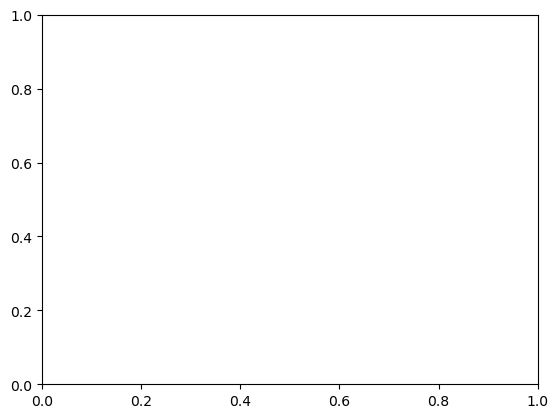

In [5]:
# Plot result
import matplotlib.pyplot as plt

def plot_result(x_label, y_label, x, y, name):
    plt.plot(x,y)
    plt.ylabel(x_label)
    plt.xlabel(y_label)
    plt.show()

steps = [1,2,3,4]
rewards = [1,2,3,4]

# TODO fixme
# model.save(primary_model_file_name)
name_plot_eps_steps = "Training Episodes Steps"
name_plot_eps_rewards = "Training Episodes Rewards"

plot_result("Episode", "Steps", rewards, steps, name_plot_eps_steps)

